In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress

In [173]:
class IMUDataset(Dataset):
    def __init__(self, df, winsize=250, stride=50, transform=None):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        self.y = torch.from_numpy(df['rir'].values).to(torch.float32)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.len = (self.X.shape[1] - winsize) // stride + 1
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        start = i * self.stride
        end = start + self.winsize
        return self.X[:,start:end], self.y[start:end].mean()


In [174]:
HZ = 100
df = pd.read_csv('data/data.csv')
session_ids = df['session_id'].unique()
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

winsize_t = 2.5 # seconds
stride_t = 0.5 # seconds
winsize = int(winsize_t * HZ)
stride = int(stride_t * HZ)

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
norm = train.mean(axis=0), train.std(axis=0)

def transform(x):
    return (x - norm[0]) / norm[1]

train_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform) for session_id in val_ids])

In [285]:
# windows = []
window_labels = []
for X, y in train_dataset:
    # windows.append(X.T.numpy())
    window_labels.append(y.item())

(array([277., 229., 186., 172., 161., 148., 145., 117.,  85., 124.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

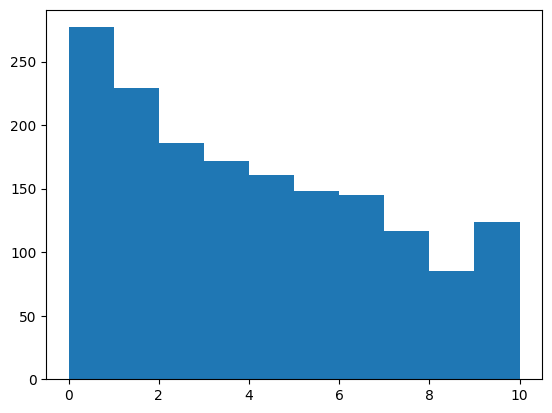

In [287]:
plt.hist(window_labels)

In [288]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 4, 3, padding=1)
        self.fc = nn.Linear(4*winsize, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [289]:
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = ConvNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

In [290]:
X,y = next(iter(trainloader))
model(X).shape

torch.Size([32, 1])

In [291]:
def train(epochs, model, trainloader, valloader, criterion, optimizer):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in trainloader:
            optimizer.zero_grad()
            y_pred = model(X).squeeze()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trainloader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in valloader:
                y_pred = model(X).squeeze()
                loss = criterion(y_pred, y)
                val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}')
    return train_losses, val_losses

In [292]:
train_losses, val_losses = train(100, model, trainloader, valloader, criterion, optimizer)

Epoch 0 train loss: 7.6815564173918505, val loss: 13.140307299296062
Epoch 1 train loss: 5.659219929805169, val loss: 12.503199724356334
Epoch 2 train loss: 5.266956164286687, val loss: 13.938967629273732
Epoch 3 train loss: 4.88210684978045, val loss: 14.54030900001526
Epoch 4 train loss: 4.6795116158632135, val loss: 12.549136384328206
Epoch 5 train loss: 4.4207766973055325, val loss: 12.367451868454616
Epoch 6 train loss: 4.323004103623903, val loss: 14.009360476334889
Epoch 7 train loss: 4.158552323396389, val loss: 11.767109974225361
Epoch 8 train loss: 4.04193626000331, val loss: 16.153961459795635
Epoch 9 train loss: 3.886028739122244, val loss: 14.979731325308482
Epoch 10 train loss: 3.9103511571884155, val loss: 13.434748303890228
Epoch 11 train loss: 3.7816036297724795, val loss: 13.48616782426834
Epoch 12 train loss: 3.6371136628664456, val loss: 15.57110067208608
Epoch 13 train loss: 3.6234324161822977, val loss: 15.337724773089091
Epoch 14 train loss: 3.5820183662267833, v

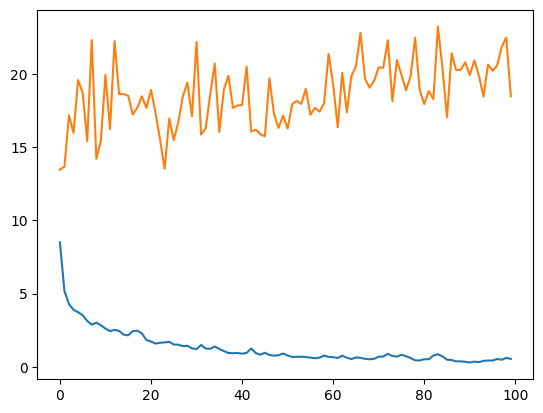

In [271]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

In [272]:
ys = []
ypreds = []
model.eval()
with torch.no_grad():
    for X, y in valloader:
        ypred = model(X).squeeze()
        ys.append(y)
        ypreds.append(ypred)
ys = torch.cat(ys)
ypreds = torch.cat(ypreds)

Text(0.5, 1.0, 'R^2: 0.03')

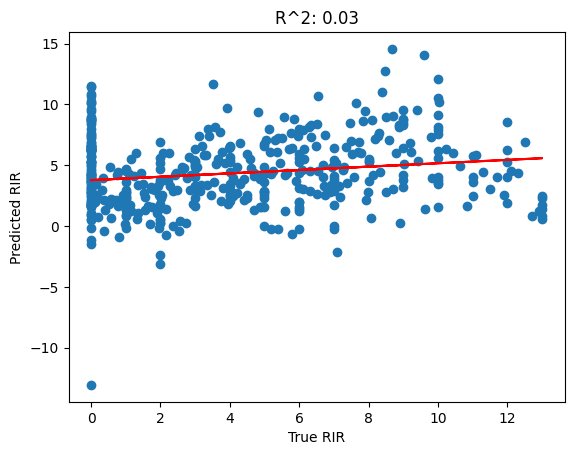

In [276]:
regr = linregress(ys, ypreds)
plt.scatter(ys, ypreds)
plt.plot(ys, regr.intercept + regr.slope * ys, color='red')
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')
plt.title(f'R^2: {regr.rvalue**2:.2f}')